# 0. Installing embedding prerequisites

If you use x86 machines or ARM (Mac M1/M2/...) chips with python 3.8, then you may benefit from `spacy` embedding.

In [2]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-21 13:31:45.719293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 13:31:47.456795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 13:31:47.456926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could no

Check that is works:

In [3]:
import spacy
nlp = spacy.load('en_core_web_md')

def embed(text: str):
    return nlp(text['Question']).vector

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395670 sha256=be5a997ee392de14312841ff6b5591ce985ba4e96a80e7a4f21caeb664a7aca5
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


# 00. Index data structure

And now let us install the NMSlib. To avoid M1 crashes please do not use prebuilt wheels.

In [5]:
!pip uninstall nmslib -y
!pip install nmslib --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 KB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 KB 24.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Skipping wheel build for nmslib, due to binaries being disabled for it.
  Created wheel for pybind11: filename=pybind11-2.6.1-py2.py3-none-any.whl size=188542 sha256=7a4dc9134e8a0cfcf49c629643240239f536111bfd034a7162d4a3edbd0b4594
  Stored in directory: /root/.cache/pip/wheels/ca/e8/9f/814ed6a46c77b66f99d4612e5f48e6b0b430ca1335a64cfc61
Successfully built pybind11
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.10.4
    Uninstalling pybind11-2.10.4:
      Successfully uninstalled pybind11-2.10.4
  Running setup.py install for nms

Check it works:

In [6]:
import nmslib

# Tensorflow & Embed

In [7]:
import tensorflow_hub as hub
embed_hub = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

def embed(text: str):
    # return ft.get_sentence_vector(text)
    return embed_hub([text])[0].numpy()

# Generate some vectors 

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Unpack it! Read it as CSV. Embed `Question`s with spacy model.

In [8]:
# for downloading jeoprady dataset
import requests
print('Downloading started')
url = 'https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip?raw=true'
req = requests.get(url)
filename = "JEOPARDY.zip"
# donwloading the file to the local file system
with open(filename,'wb') as output_file:
    output_file.write(req.content)
print('Downloading Completed')

In [9]:
MAX = 30000
DATASET_FILENAME = 'JEOPARDY_CSV.csv'

In [10]:
# For unzipping
import zipfile

# extract the zip file
with zipfile.ZipFile("/content/JEOPARDY.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [11]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)
        
print("Strings:", len(strings))

Strings: 30000


In [12]:
import tqdm
import pickle
import os

vectors = np.zeros((MAX, 512))

if os.path.exists('vectors'):
    print("Vectors are precomputed! Loading ...", end='')
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
    print(" done")
else:
    print("Vectors are not precomputed. Computing ...", end='')
    for i, line in enumerate(tqdm.tqdm(strings)):
        vectors[i, :] = embed(line['Question'])
    print(" dumping ...", end='')
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)
    print(" done")

Vectors are not precomputed. Computing ...

100%|██████████| 30000/30000 [17:25<00:00, 28.70it/s]


 dumping ... done


In [13]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 512) | strings: 30000


# 1. Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [14]:
import nmslib

def get_index(
        vectors, 
        method='hnsw', 
        space='cosinesimil', 
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()
    
    if cutoff is not None:
        vectors = vectors[:cutoff]
    
    index = nmslib.init(method=method, space=space, space_params = {
        "efConstruction": efConstruction,
        "efSearch": efSearch,
        "M": M,
    })
    index.addDataPointBatch(vectors)
    if method == 'hnsw':
        index.createIndex({'post': postprocessing_optimization_level}, print_progress=True)
    else:
        index.createIndex(print_progress=True)
    return index


def find_for_vector(index, vector, nn) -> list:
    ids, _ = index.knnQuery(vector, k=nn)
    return list(ids)


def find_for_batch(index, batch, nn) -> list:
    result = index.knnQueryBatch(batch, k=nn, num_threads=8)
    return [list(k[0]) for k in result]

## Construct buckets with ground truth

In [15]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra', 
          'cooking', 'armory', 'war', 'history', 'money', 'books', 
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry', 
          'stars', 'science fiction', 'languages', 'clothes']
bucket_vectors = [embed(t) for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect ACCURATE nearest neighbours with flat index (no index)

In [16]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [17]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [18]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    ground_truth[cutoff] = bucket_results

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [19]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    # predictions
    a = sorted_result[:N]
    # the groun truth
    b = sorted_ground_truth[:N]
    return len(set(a).intersection(b))


In [20]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

700 500 350 0
700 500 350 0
700 500 350 0
700 500 350 0
700 500 350 0


Discuss the values.
- Why do you see these numbers? 
- Why are they equal?

# 2. Test HNSW

Create an index with default settings and assess its recall numbers.

In [21]:
hnsw = get_index(vectors, method='hnsw')

In [22]:
vector_id = 5
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [100, 1000, 2000]:
    ids = find_for_vector(hnsw, bucket_vectors[5], nn=n)
    print(f"recall@{n} =", recall(ids, ground_truth[DS[-1]][5], n))

recall@100 = 100
recall@1000 = 554
recall@2000 = 554


Discuss: why recall drops with the growth of N?

# 3. Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [23]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

In [25]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()
    
    I = get_index(vectors, method='hnsw', efConstruction=ef, efSearch=ef, M=M, cutoff=D)
    
    
    build_time = time.time() - start
    
    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.
    
    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)
    
    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results) 
    
    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

100%|██████████| 60/60 [21:08<00:00, 21.14s/it]


In [26]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", 
           "search time 1000", "recall@100", "recall@1000", "recall@100*"]
d = {}
for i, h in enumerate(headers):
    d[headers[i]] = [r[i] for r in result]

df = pd.DataFrame(d)
# df.to_pickle('results.pkl')
df

,M,D,ef,build time,search time 100,search time 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,2.903579,0.123142,0.224653,99.9810,425.9380,99.9810
1,8,2000,200,1.349838,0.115657,0.218128,99.9645,427.0775,99.9645
2,8,2000,400,1.564412,0.111866,0.201041,99.9975,427.9825,99.9975
3,8,5000,100,4.799228,0.119602,0.226384,99.9325,471.9410,99.9325
4,8,5000,200,4.089578,0.138128,0.247061,99.9405,472.1980,99.9405
5,8,5000,400,4.854168,0.124066,0.243368,99.9440,472.5055,99.9440
6,8,10000,100,12.886716,0.177030,0.342101,99.9070,490.6890,99.9070
7,8,10000,200,11.618291,0.172865,0.323886,99.8605,488.1375,99.8605
8,8,10000,400,11.461911,0.142029,0.274228,99.9425,489.7930,99.9425
9,8,20000,100,30.967015,0.225737,0.390831,99.7985,501.1045,99.7985


Discuss, how parameters (using the table) affect perfromance?

### * Load results (if needed)

(NB: for some reason `pyplot` does not survive together with `nmslib` in Windows. So you may save we save and load).

In [27]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", "search time 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
# df = pd.read_pickle('results.pkl')

## Displaying results

Let us display them now!

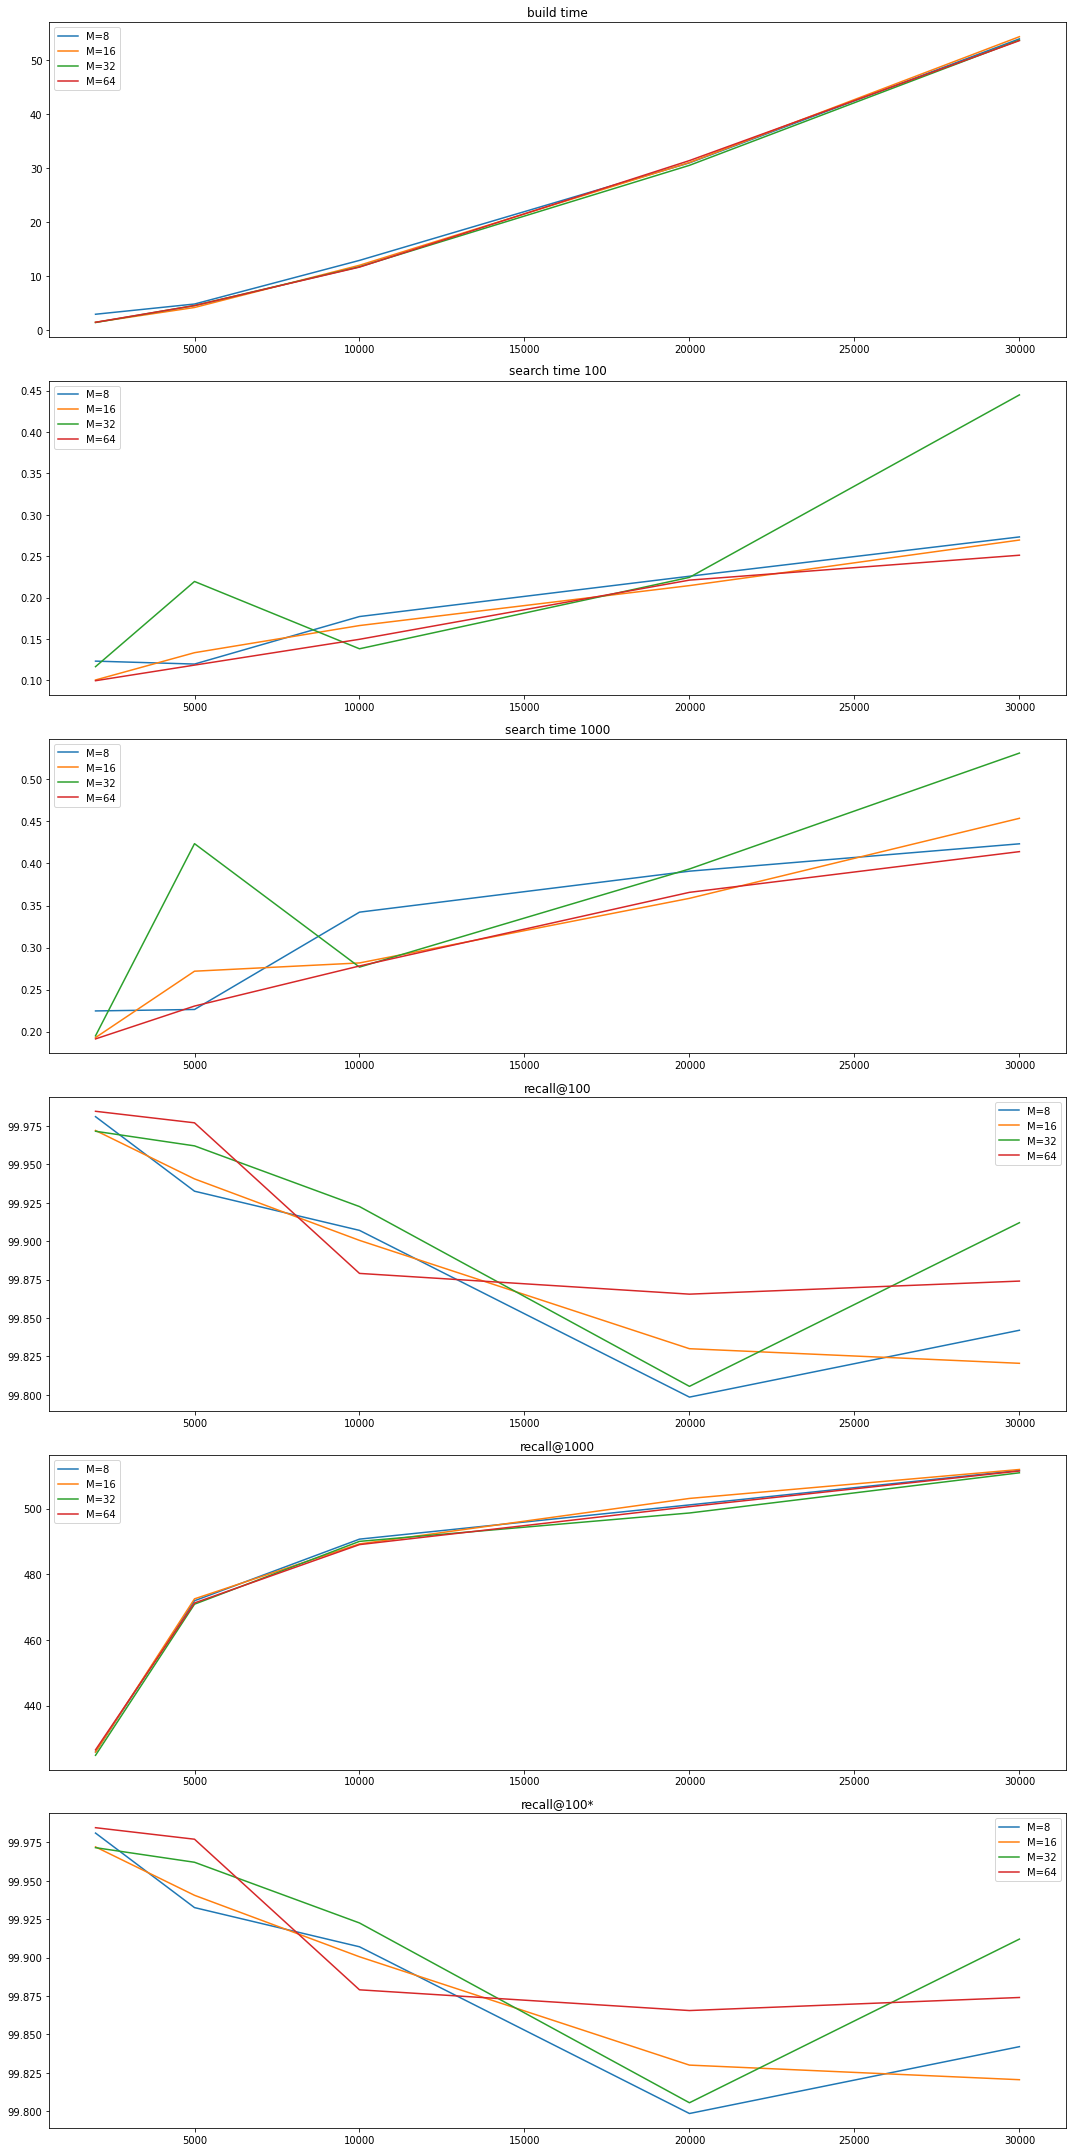

In [28]:
%matplotlib inline 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        # print(MS[j], k)
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()
        
plt.tight_layout()
plt.show()